In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
from utils import create_supervised_pair, supervised_contrasive_loss, Similarity
import matplotlib.pyplot as plt
import statistics

#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
def load_examples(file_path, do_lower_case=True):
    examples = []
    
    with open('{}/seq.in'.format(file_path),'r',encoding="utf-8") as f_text, open('{}/label'.format(file_path),'r',encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            
            e = Inputexample(text.strip(),label=label.strip())
            examples.append(e)
            
    return examples

In [3]:
class Inputexample(object):
    def __init__(self,text_a,label = None):
        self.text = text_a
        self.label = label

In [4]:
# create custom dataset class
# ===  =  Hint =  ===
# can train on two condition 
# 1.) trainig training with supervise contrastive loss and cross entropy loss using in question 5.) 
#    when self.repeated_label == True:
# 2.) train only cross entropy loss use in question 4.)
#    when self.repeated_label == False:

class CustomTextDataset(Dataset):
    def __init__(self,labels,text,batch_size,repeated_label:bool=False):
        self.labels = labels
        self.text = text
        self.batch_size = batch_size 
        self.count = 0 
        self.batch_labels = []
        self.repeated_label = repeated_label
        
        if self.repeated_label == True:
            print("Train on Combine between Supervised Contrastive and Cross Entropy loss")
            
        else:
            print("Train on Cross Entropy loss")
            
        
        print("len of dataset :",len(self.labels))
              
     
          

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        
        
        # write code here for 1)
        if self.repeated_label == True:
        
            if len(np.unique(self.batch_labels)) == self.batch_size - 1:


                while True:
                    idx = np.random.choice(len(self.labels))

                    if self.labels[idx]  in self.batch_labels:

                       
                        break

        self.batch_labels.append(self.labels[idx])
        
        label = self.labels[idx]
        
        data = self.text[idx]
        
        sample = {"Class": label,"Text": data}


    
        return sample

In [5]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 4 
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [6]:
path_5shot = f'./HWU64/train_5/'
valid_path = f'./HWU64/valid/'
test_path = f'./HWU64/test/'

In [7]:
# Download data fewshot 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# load data
train_samples = load_examples(path_5shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)


print("===== small train set ====")

for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)


train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)



print("===== validation set ====")

data = []
labels = []

for i in range(len(valid_samples)):
    data.append(valid_samples[i].text)
    labels.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)



print("===== test set ====")

data = []
labels = []
    
for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

===== small train set ====
Train on Cross Entropy loss
len of dataset : 320
===== validation set ====
Train on Cross Entropy loss
len of dataset : 1076
===== test set ====
Train on Cross Entropy loss
len of dataset : 1076


In [8]:
from transformers import BertModel, BertTokenizer
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
def freeze_layers(model,freeze_layers_count:int=0):

        """
        model : model object that we create 
        freeze_layers_count : the number of layers to freeze 
        """
        # write the code here
    
        # should not more than the number of layers in a backbone
        assert freeze_layers_count <= 12

        for name, param in model.named_parameters():
           

            keys = name.split(".")

            if str(freeze_layers_count) in keys or 'classifier' in keys:
                break
            
            param.requires_grad = False 


        #print all parameter that we want to train from scratch 
        
        for name, param in model.named_parameters():
            
            if param.requires_grad == True:
                 
                print(name)
        
    
        return model     

In [10]:
#  no gradients needed
def test(model,test_loader,data_size):
    
    correct = 0
         
    with torch.no_grad():
        for (idx, batch) in enumerate(test_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)
            
            # Foward pass 
            outputs = model(**inputs,labels=labels)

            # get loss and output 
            loss, logits = outputs[:2]
            
            _, predicted = torch.max(logits, -1)
            
            
           
         
            correct += (predicted == labels).sum().item()
            
    print("correct :",correct)
    print("total :",data_size)
         
    return correct / data_size

In [11]:
def train(model,optimizer,train_loader,valid_loader,epochs:int=30):

    train_loss_hist = [] 
    valid_loss_hist = []
    
    train_acc_hist = []
    valid_acc_hist = []
    

    test_acc = []

    min_valid_loss = np.inf
   
    for e in range(epochs):  # loop over the dataset multiple times

       
        model.train()
        correct = 0
        running_loss = 0.0
       
    
        for (idx, batch) in enumerate(train_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")


            #assert len(np.unique(batch["Class"])) < len(batch["Class"])  
            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


             # clear gradients
            optimizer.zero_grad()

            # Foward pass 
            #print(inputs)
            outputs = model(**inputs,labels=labels)

            # get loss and output 
            loss, logits = outputs[:2]
            
            
            # Calculate gradients
            loss.backward()
            
           # Update Weights
            optimizer.step()
            
            # Calculate Loss
            running_loss += loss.item()
            
            #calculate nums of correction 
            correct += (torch.max(logits,dim=-1)[1] == labels).sum()
            
           
            
            #clear_output(wait=True)
        
        train_loss_hist.append(running_loss/len(train_data))
        train_acc_hist.append(correct/len(train_data))
        
        
        print(f'======  Epoch {e+1} ====== ')
        print(f' Training Loss: {running_loss/len(train_data)}, \t\t Training acc: {correct/len(train_data)}')
        
        print("train correct : ",correct)
        print("train total :",len(train_data))
        
        running_loss = 0.0
        correct = 0
        model.eval()     # Optional when not using Model Specific layer
        log_correct = []
        
        
        for (idx, batch) in enumerate(valid_loader):

            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)

            # Foward pass 
            outputs = model(**inputs,labels=labels)

            # get loss and output 
            loss, logits = outputs[:2]
        
            
            # Calculate Loss
            running_loss += loss.item()
            
            #calculate nums of correction 
            correct += (torch.max(logits,dim=-1)[1] == labels).sum()
            
           
        #  add to collect log 
        
        valid_loss_hist.append(running_loss/len(valid_data))
        valid_acc_hist.append(correct/len(valid_data))
        
        print(f' Validation Loss: {running_loss/len(valid_data)}, \t\t Validation acc: {correct/len(valid_data)}')
        
        print("valid correct : ",correct)
        print("valid total :",len(valid_data))
       
        # save best current model 
        if min_valid_loss > (running_loss/len(valid_data)):
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{running_loss/len(valid_data):.6f}) \t Saving The Model')
            min_valid_loss = running_loss/len(valid_data) 
            torch.save(model.state_dict(), 'saved_model.pth')
            
           
    return (train_acc_hist, train_loss_hist), (valid_acc_hist, valid_loss_hist)  

In [12]:
# download config of Roberta config 
from transformers import BertModel, BertConfig
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_class)

model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)

# move to model to device that we set
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# download config of Roberta config 
from transformers import BertModel, BertConfig
from transformers import BertTokenizer, BertForSequenceClassification
import torch

config = BertConfig()

config.num_labels = num_class

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = num_class)

model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)

model = model.to(device)

In [19]:
model = freeze_layers(model,freeze_layers_count=12)
# Using adam optimizer 
optimizer= AdamW(model.parameters(), lr=lr)

classifier.weight
classifier.bias
classifier.out_proj.weight
classifier.out_proj.bias


In [27]:
train_log, valid_log = train(model,optimizer,train_loader,valid_loader,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 1.344689305126667, 		 Training acc: 0.0062500000931322575
train correct :  tensor(2, device='cuda:2')
train total : 320
 Validation Loss: 1.185883424095948, 		 Validation acc: 0.022304832935333252
valid correct :  tensor(24, device='cuda:2')
valid total : 1076
Validation Loss Decreased(inf--->1.185883) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 1.1491874963045121, 		 Training acc: 0.02500000037252903
train correct :  tensor(8, device='cuda:2')
train total : 320
 Validation Loss: 1.1459110226329818, 		 Validation acc: 0.02509293705224991
valid correct :  tensor(27, device='cuda:2')
valid total : 1076
Validation Loss Decreased(1.185883--->1.145911) 	 Saving The Model
======  Epoch 3 ====== 
 Training Loss: 1.117638850212097, 		 Training acc: 0.04374999925494194
train correct :  tensor(14, device='cuda:2')
train total : 320
 Validation Loss: 1.0776710013917832, 		 Validation acc: 0.05018587410449982
valid correct :  tensor(54, device

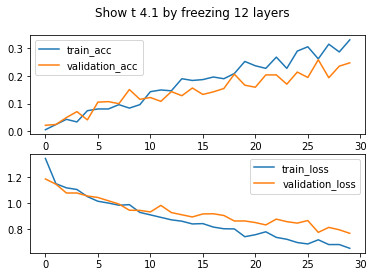

In [28]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show t 4.1 by freezing 12 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [29]:
#  no gradients needed
def test(model,test_loader,data_size):
    
    correct = 0
         
    with torch.no_grad():
        for (idx, batch) in enumerate(test_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)
            
            # Foward pass 
            
            outputs = model(**inputs,labels=labels)
            
            # get loss and output 
            loss, logits = outputs[:2]
            
            _, predicted = torch.max(logits, -1)
            
            
           
         
            correct += (predicted == labels).sum().item()
            
    print("correct :",correct)
    print("total :",data_size)
         
    return correct / data_size

In [30]:
test_acc = test(model,test_loader=test_loader,data_size=len(test_data))

correct : 261
total : 1076


In [31]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 24.25650557620818 %


!pip install bertviz